# Unsupervised Learning of FIFA Midfielders

The goal of this project is to act as an example of a basic clustering process.  At the end we
will tackle dimensionality reduction for the sake of visualizing the cluster as well.

### Clustering
In a general sense Clustering Analysis is the grouping of data elements based on how similar they
are to other data points.  One of the most popular (and basic) clustering algorithms is referred to as
K-Means.  One of the downsides to K-Means is that it only deals with numerical features because it's algorthm
relies heavily on the means of the found clusters.  If you are dealing instead with Categorical data
one could use the very similar K-Modes clustering algorithm.  Last but not least, if dealing with mixed date
(both numerical and categorical) one could use K-Prototype Clustering, which serves as a combination of K-Means for
numerical features and K-Modes for categorical.

We will talk about which clustering algorithm we used and why later on.

### Opening & Exploring the Data


In [155]:
# IMPORTS
from sklearn import preprocessing
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np
import prince
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")
colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen']
%matplotlib inline

Now that we have imported our dependencies (python libraries) we can go ahead and load the data
into a dataframe.  The dataset we are using today is built from EA's video game FIFA 2020.  It
serves as a great source for player skill ratings, and is often very popular on kaggle for this
reason.


In [156]:
data = pd.read_csv(r'players_20.csv')
data.head()


,sofifa_id,short_name,nationality,club,overall,potential,team_position,age,height_cm,weight_kg,...,mentality_penalties,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes
0,190871,Neymar Jr,Brazil,Paris Saint-Germain,92,92,CAM,27,175,68,...,90,94,27,26,29,9,9,15,15,11
1,192985,K. De Bruyne,Belgium,Manchester City,91,91,RCM,28,181,70,...,79,91,68,58,51,15,13,5,10,13
2,177003,L. Modrić,Croatia,Real Madrid,90,90,RCM,33,172,66,...,82,92,68,76,71,13,9,7,14,9
3,215914,N. Kanté,France,Chelsea,89,90,RCM,28,168,72,...,54,85,90,91,85,15,12,10,7,10
4,189511,Sergio Busquets,Spain,FC Barcelona,89,89,CDM,30,189,76,...,60,93,90,86,80,5,8,13,9,13


We have a trimmed down version of this dataset so that we can streamline this process.  Normally
in projects of this nature quite a bit of time is spent exploring all of the features to decide
which metrics would be useful for clustering on.

Feature selection is quite important to any machine learning algorithm, and understanding the domain
is vital is making these decisions.  Since I was in a somewhat expedited process when putting this together
I trimmed down the features from ym domain knowledge as a soccer fan.

As you can see from our data preview, we have quite a few features still in our dataset.  If there
was a specific goal behind this project it would be easier to limit the features even farther.

*For example, if our goal was to see what countries produce the best midfielders we could cluster based
solely on features the best midfielders exhibit and then after the process look at the clusters
to see if there is a natural grouping of skill levels (low, mid, and highly skilled)*

Next up in the exploration of our data is to understand the metrics we have:
- Feature Name
- Data Type
- Unique Number of Values

In [157]:
def get_cat(series: pd.Series, empty_flag: bool) -> str:
    """
    :param series: a pandas series of data (should be of one data type)
    :param empty_flag: a boolean to call out an empty column (containing all NaNs)
    :return: a string that is the 'category of the datatype'

    This function will take a given series and return a generalized category for the datatype.
    This is necessary for readability as df.dtypes will return ungrouped types (i.e. float64, int64)
    as well as return some options that do not provide much insight (i.e. object)
    """
    if empty_flag:  # Catch Empty Columns
        return 'Empty'
    elif pd.api.types.is_numeric_dtype(series):
        return 'Numerical'
    elif pd.api.types.is_datetime64_dtype(series):
        return 'Date'
    elif pd.api.types.is_bool_dtype(series):
        return 'Boolean'
    elif pd.api.types.is_categorical_dtype(series):
        return 'Categorical'
    elif pd.api.types.is_string_dtype(series):
        return 'Text'
    else:  # Catches all others for review
        return 'Unknown'


def col_categories(data: pd.DataFrame):
    """
    :param data: a pandas Dataframe consisting of columns of data you want to explore their categories
    :return: None
    Prints the column name and data type of each column in the dataframe
    """
    # if data.dropna().empty:  # Catches Error
    #     raise ValueError('DataFrame Provided Contains is either empty or only contains NaNs')
    #     # sys.exit(1)
    for col in data.columns:  # For Each Column
        if data[col].dropna().empty:  # Catch Empty Columns
            empty = True  # Set Flag
        else:
            empty = False  # Set Flag
        count = data[col].nunique()
        print(col, ': ', get_cat(data[col], empty), ' -- #Unique: ', count)  # Print and Call Column Categories

In [158]:
col_categories(data)

sofifa_id :  Numerical  -- #Unique:  608
short_name :  Text  -- #Unique:  603
nationality :  Text  -- #Unique:  70
club :  Text  -- #Unique:  274
overall :  Numerical  -- #Unique:  28
potential :  Numerical  -- #Unique:  20
team_position :  Text  -- #Unique:  11
age :  Numerical  -- #Unique:  20
height_cm :  Numerical  -- #Unique:  34
weight_kg :  Numerical  -- #Unique:  33
player_traits :  Text  -- #Unique:  212
attacking_crossing :  Numerical  -- #Unique:  54
attacking_finishing :  Numerical  -- #Unique:  59
attacking_heading_accuracy :  Numerical  -- #Unique:  55
attacking_short_passing :  Numerical  -- #Unique:  36
attacking_volleys :  Numerical  -- #Unique:  59
skill_dribbling :  Numerical  -- #Unique:  42
skill_curve :  Numerical  -- #Unique:  59
skill_fk_accuracy :  Numerical  -- #Unique:  65
skill_long_passing :  Numerical  -- #Unique:  48
skill_ball_control :  Numerical  -- #Unique:  37
movement_acceleration :  Numerical  -- #Unique:  55
movement_sprint_speed :  Numerical  -- 

Looking through the data we can gain some basic understanding of the dataset

- sofifa_id is the player index
- Nationality / Club / Position may be interesting to evaluate post cluster
    - Clustering on these may take away the idea of these clusters signifying performance
- Player traits is a comma separate list of categorical variables
- Lots of goalkeeping features that we will not need for this Analysis
- Overall & Potential are likely Collinear with some of the other stats, and should be removed
for now


So our data transformation is fairly simple in this case.  First we will separate our the metrics
we want to compare post analysis into its own dataframe.  This will allow us to join these metrics
back in after we have our results by merging on the player index.

In [159]:
# Define the player DF for later merging
player = data[['sofifa_id', 'short_name', 'nationality','club',	'overall', 'potential',	'team_position']]


Next we will deal with the categorical variables we are interested in using.  There are two approaches
we could take.
- Use K-Prototype for mixed data since we have both numerical and categorical data
- Convert our categorical data to numerical so that we can use K-Means

In our dataset's case where there is really only one feature we are interested in that is categorical
I find it better to just translate it to a numeric than use a much more complex and less efficient
process.  So to convert this categorical data we will split the string (comma seperated list) and then
"dummify" the categories.

*Dummifying the variable means taking all the value options for this metric and making them their
own feature that is now a binary (and numerical) feature.  Aka, If a player is a Long Shot Taker he
will have a value of one in that column, and would have a zero if he did not have that trait.  it is
often useful for people to think of this as a 'Flag'*

In [160]:
# Split on commas after converting to a string, and then dummify the variable renaming each column
data = pd.concat([data,data.player_traits.str.get_dummies(sep=',').rename(lambda c: 'trait_' + c, axis='columns')],
                 axis=1)

Now the last big step we discussed is removing a lot of the columns we either converted or seperated
into their own dataframe for joining in later.

**Remember to not remove 'sofifa_id' as this serves as our key to merge the data back in later.**

In [161]:
data.drop(columns=['short_name', 'player_traits', 'nationality','club',	'overall', 'defending_sliding_tackle',	'team_position', 'potential'], inplace=True)

Now lets re-evaluate the columns again

In [162]:
col_categories(data)


sofifa_id :  Numerical  -- #Unique:  608
age :  Numerical  -- #Unique:  20
height_cm :  Numerical  -- #Unique:  34
weight_kg :  Numerical  -- #Unique:  33
attacking_crossing :  Numerical  -- #Unique:  54
attacking_finishing :  Numerical  -- #Unique:  59
attacking_heading_accuracy :  Numerical  -- #Unique:  55
attacking_short_passing :  Numerical  -- #Unique:  36
attacking_volleys :  Numerical  -- #Unique:  59
skill_dribbling :  Numerical  -- #Unique:  42
skill_curve :  Numerical  -- #Unique:  59
skill_fk_accuracy :  Numerical  -- #Unique:  65
skill_long_passing :  Numerical  -- #Unique:  48
skill_ball_control :  Numerical  -- #Unique:  37
movement_acceleration :  Numerical  -- #Unique:  55
movement_sprint_speed :  Numerical  -- #Unique:  60
movement_agility :  Numerical  -- #Unique:  52
movement_reactions :  Numerical  -- #Unique:  42
movement_balance :  Numerical  -- #Unique:  55
power_shot_power :  Numerical  -- #Unique:  46
power_jumping :  Numerical  -- #Unique:  61
power_stamina :

## Exploring the Data

Now will serve as a good time to really dig into the data that will serve as our data in
the clustering algorithm we apply.  I will not spend too much effort in this process since it
is not related to an actual business issue and instead is to be used as a teaching aide.  However,
I will provide a few examples of how you could explore this data
- Distribution Analysis through Visuals
    - Histograms
    - Probability Density Functions
- Descriptive Statistics of the features
- Correlation Heat Maps to understand Relationships


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000011176EA0E48>,
      dtype=object)

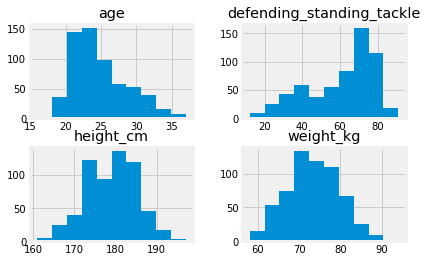

In [163]:
# Create quick Histograms to understand the distribution of the metrics
data[['age', 'height_cm', 'weight_kg', 'defending_standing_tackle']].hist()


In [164]:
# Grab basic descriptive statistics for each numeric feature in the dataframe
data.describe()

# # Export for Review
# data.describe().to_csv(r'descriptive_stat.csv')

,sofifa_id,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,trait_Inflexible,trait_Injury Free,trait_Injury Prone,trait_Leadership,trait_Long Shot Taker (CPU AI Only),trait_Long Throw-in,trait_Power Free-Kick,trait_Selfish,trait_Skilled Dribbling,trait_Speed Dribbler (CPU AI Only)
count,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,...,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000,608.000000
mean,214725.598684,24.901316,178.888158,73.182566,67.815789,63.574013,58.666118,76.623355,60.532895,75.485197,...,0.004934,0.037829,0.065789,0.064145,0.003289,0.026316,0.054276,0.146382,0.001645,0.008224
std,24906.466818,3.709394,6.067494,6.224882,9.808493,10.980038,11.164136,6.147922,12.207793,7.069654,...,0.070128,0.190939,0.248118,0.245212,0.057307,0.160204,0.226749,0.353779,0.040555,0.090385
min,20775.000000,16.000000,161.000000,58.000000,33.000000,21.000000,30.000000,44.000000,26.000000,37.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,202071.250000,22.000000,175.000000,69.000000,63.000000,58.000000,51.000000,73.000000,52.000000,72.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,220748.500000,24.000000,179.000000,73.000000,68.000000,65.000000,59.000000,77.000000,62.000000,76.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,232719.500000,27.000000,183.000000,77.000000,74.000000,71.000000,67.000000,81.000000,69.000000,80.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,251221.000000,37.000000,197.000000,94.000000,93.000000,89.000000,90.000000,92.000000,90.000000,96.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


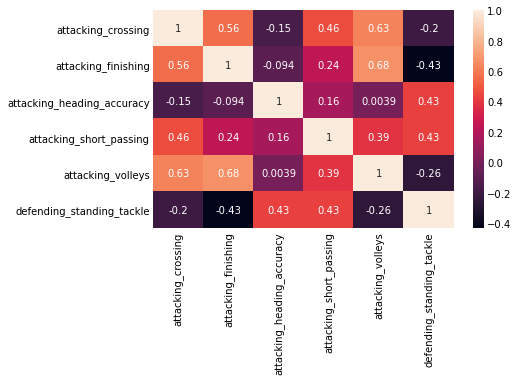

In [165]:
# # Export to CSV for review
# data.corr().to_csv(r'Corr_Mat.csv')

# Features to generate a visual
features = ['attacking_crossing',
            'attacking_finishing',
            'attacking_heading_accuracy',
            'attacking_short_passing',
            'attacking_volleys',
            'defending_standing_tackle']
corr_matrix = data[features].corr()
sns.heatmap(corr_matrix, annot=True)


These are all opportunities to learn more about your dataset and may provide insight
into solving certain problems that arise.  For example, we see that standing tackle has a negative
correlation with finishing.

This is one area we could possibly see become a differentiator for clustering.  You're either have
defensive duties, or you don't as a midfielder, and those that do not have to potentially make up for it
by scoring more goals.  We also see decently strong correlations between finishing and volleys,
which could serve as a future indicator that we could reduce these variables to a single metric
for the sake of dimensional reduction.

Now that we have more understanding of our dataset, we can move onto areas that there may be issues.  Mainly
referring to missing data in certain columns.  While some algorithms have techniques for this process
other rely on the user imputing the results.

In [166]:
print("-------Percentage of Null values count------")
for feature in data.columns.values:
    print(feature,"-->",100*data[feature].isnull().sum()/len(data))


-------Percentage of Null values count------
sofifa_id --> 0.0
age --> 0.0
height_cm --> 0.0
weight_kg --> 0.0
attacking_crossing --> 0.0
attacking_finishing --> 0.0
attacking_heading_accuracy --> 0.0
attacking_short_passing --> 0.0
attacking_volleys --> 0.0
skill_dribbling --> 0.0
skill_curve --> 0.0
skill_fk_accuracy --> 0.0
skill_long_passing --> 0.0
skill_ball_control --> 0.0
movement_acceleration --> 0.0
movement_sprint_speed --> 0.0
movement_agility --> 0.0
movement_reactions --> 0.0
movement_balance --> 0.0
power_shot_power --> 0.0
power_jumping --> 0.0
power_stamina --> 0.0
power_strength --> 0.0
power_long_shots --> 0.0
mentality_aggression --> 0.0
mentality_interceptions --> 0.0
mentality_positioning --> 0.0
mentality_vision --> 0.0
mentality_penalties --> 0.0
mentality_composure --> 0.0
defending_marking --> 0.0
defending_standing_tackle --> 0.0
goalkeeping_diving --> 0.0
goalkeeping_handling --> 0.0
goalkeeping_kicking --> 0.0
goalkeeping_positioning --> 0.0
goalkeeping_ref

We are lucky that this dataset is so clean.  While I do not have to fill in any of these metrics I will
give two possible solutions:
- Numerical Data
    - Replace with the mean of your set
    - Turn missing data into a binary variable as well to evaluate if there is a bias to missing data
- Categorical Data
    - Replace with the mode of your set
    - Make a category for missing data to see if there is bias in those rows with missing data

We do not need to worry about that, but it is always nice to be sure by dropping any columns that
are completely empty or rows that have ANY empty values.  If your data was full of missing data, I would
not suggest such an extreme action, but in our case all of the data appears to be there so this
will just serve as assurance.

In [167]:
# Drop the columns/rows where all elements are nan:
data.dropna(axis=1, how='all', inplace=True)
data.dropna(axis=0, inplace=True)  # For future should instead impute these

Now comes the question of should we standardize our numerical features.

#### Standardization is the process of centering your feature around 0 with a standard deviation of 1

In this case it does not make sense to standardize or normalize.  Since our features are already on mostly
a comparable scale of 0 - 100 they are already in a state well suited for this project.  However,
it is worth knowing the process in case you are analyzing datasets with vastly different scales.

I will first establish a list of numerical columns and then apply a standardizer to the data.  It
will be commented our for this project, but it is useful to know.  *We ignore categorical columns
as they cannot be standardized*

In [168]:
# # Establish numerical columns, This becomes useful for K-Prototype as well
# num_col = data.select_dtypes(include=np.number).columns.tolist()
# num_col.remove('sofifa_id')

# # For each numerical column transform the data to a standardize scale
# for i in num_col:
#     data[i] = preprocessing.StandardScaler().fit_transform(data[[i]])

Now we will grab our data set in an array of values, this will remove column headers and
set the data into a format we can use for our algorithm.


In [169]:
# Grab only the values as an array
X = data[data.columns.values[1:]].values

*It is important to remember that if we were going to use K-Modes or even more likely for this project,
K-Prototype we would also need to establish a list of category columns by index.  The process
of how to do this is commented out below:*

In [170]:
# # Utilize sets to remove duplicates and allow simple operations
# cat_col = list(set(data.columns) - set(num_col))
# cat_col.remove('sofifa_id')

# # We need indexes for the K-Prototype algo, so we created a sorted list here
# # We need to subtract 1 from the loc due to us removing the sofifa_id column from our array earlier (named X)
# cat_col = sorted([data.columns.get_loc(c) - 1 for c in cat_col if c in data])


Now we are almost ready to cluster.  Unfortunately one of the largest downsides to K-Means and alike algorithms
is that they require the user to provide the number of clusters.  This is due to how the algoriothm works in which
the process starts by picking arbitrary clusters in the data set, thus it needs to know how many to pick.

To do this there is a technique generally accepted referred to as the **Elbow Method**
You are essentially plotting the explained variation as a function of the number of clusters.
To do this you have to run the algorithm numerous times to evaluate this metric.  If there
is a good ability to cluster from the data set you should see a bench in the curve (often referred to as the
elbow) in which lies the optimum amount of clusters.

*Of note, if there is not an 'elbow' in your data it is possible that your data does not contain clusters.
Or that this algorithm will not be able to pick up the cluster.  For example, the algorithm known as DBSCAN is
useful in finding changes in density in a data set, this may be able to find clusters in your data where
K-Means or Hierarchical will not.  This is why it is important to know your data and domain as best
you can, because if you find no clusters you may have chosen the wrong method.*

*For methods like K-Prototype, clustering is a much slower process than K-Means which is remarkably fast.
Due to this I have commented out a simple sampling method one could use to be able to generate an estimate
of the elbow method visual without waiting hours.  Be cognizant of the size variable because you want
it to be large enough to be a good representation of the population, but small enough to allow quick processing.*

([<matplotlib.axis.XTick at 0x11176d15c88>,
 <a list of 20 Text major ticklabel objects>)

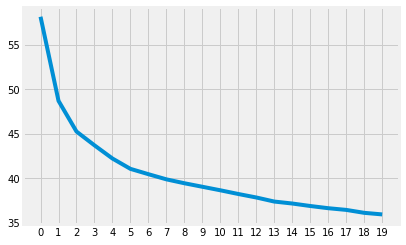

In [182]:
# # For Sampling
# X = X[np.random.choice(len(X), size=300, replace=True,)]

#Choosing optimal K
cost = []
for num_clusters in list(range(1,21)):
    kmn = KMeans(n_clusters=num_clusters)
    kmn.fit_predict(X)

    # Numpy implementation of the average euclidean distance from points to their cluster midpoint (mean)
    cost.append(sum(np.min(cdist(X, kmn.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

plt.plot(cost)
plt.xticks(np.arange(0, 20, 1))

In [172]:
kmn = KMeans(n_clusters=5)
clusters = kmn.fit_predict(X)


In [173]:
data['Cluster'] = kmn.labels_

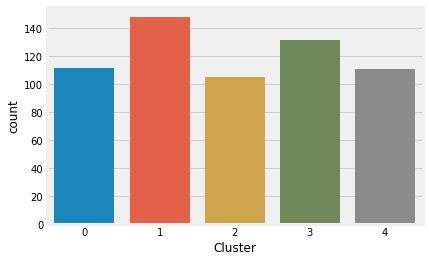

In [174]:
sns.countplot(x='Cluster', data = data)


Step 4: Dimensionality Reduction ###
Now we want to visualize the data from n diminesiton to 2 dimesion so we have to reduce the dimensionality of the
data.since our data has both categorical and numerical values so we have to use "factor analysis for mixed data" technique
"Prince" package has this implementation

In [175]:
pca = prince.PCA(n_components=2, copy=True, check_input=True, engine='auto', n_iter=10, rescale_with_mean=True, rescale_with_std=True)
pca = pca.fit(data.drop(columns=['sofifa_id','Cluster']))
pca.row_coordinates(data.drop(columns=['sofifa_id','Cluster']))

,0,1
0,-10.618878,1.654832
1,-7.994449,-5.506886
2,-7.198223,-2.366602
3,-0.468328,-2.984680
4,0.637165,-6.529905
...,...,...
603,2.461453,3.826034
604,8.499120,8.419898
605,10.244831,7.587253
606,9.510532,5.672698


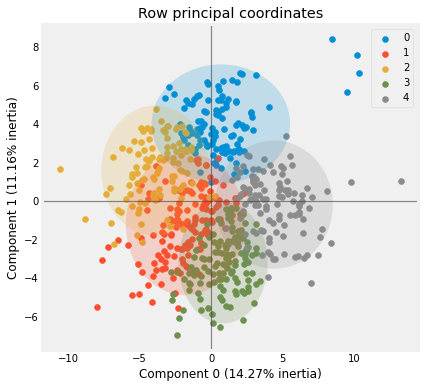

In [176]:
ax = pca.plot_row_coordinates(data.drop(columns=['sofifa_id','Cluster']), ax=None, x_component=0, y_component=1, ellipse_outline=False,
                               ellipse_fill=True, show_points=True, color_labels=data['Cluster'])





In [177]:
# # Step 5: profile the clusters (for a target variable)
# data.groupby('Cluster')['Rx'].mean().reset_index()
data = pd.merge(left=data, right=player, how='left', on='sofifa_id')
# data.to_csv(r'test.csv', index=False)

In [178]:
data.groupby('Cluster')['age'].mean().reset_index()

,Cluster,age
0,0,22.241071
1,1,25.601351
2,2,26.580952
3,3,26.681818
4,4,22.945946


In [179]:
data.groupby('Cluster')['overall'].mean().reset_index()

,Cluster,overall
0,0,71.830357
1,1,78.425676
2,2,79.857143
3,3,78.613636
4,4,72.837838


In [180]:
data[data['Cluster'] == 4].describe()

,sofifa_id,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,trait_Leadership,trait_Long Shot Taker (CPU AI Only),trait_Long Throw-in,trait_Power Free-Kick,trait_Selfish,trait_Skilled Dribbling,trait_Speed Dribbler (CPU AI Only),Cluster,overall,potential
count,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,111.000000,...,111.000000,111.0,111.0,111.000000,111.000000,111.0,111.000000,111.0,111.000000,111.000000
mean,227043.765766,22.945946,180.504505,74.405405,57.225225,49.747748,61.261261,73.558559,45.684685,68.234234,...,0.063063,0.0,0.0,0.009009,0.027027,0.0,0.009009,4.0,72.837838,80.234234
std,14760.913270,2.478408,5.501857,6.036824,10.552625,10.303105,8.719583,3.716510,9.449369,6.108050,...,0.244179,0.0,0.0,0.094916,0.162898,0.0,0.094916,0.0,3.049711,2.575955
min,158438.000000,19.000000,167.000000,60.000000,33.000000,21.000000,32.000000,65.000000,26.000000,37.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.0,69.000000,77.000000
25%,220134.000000,21.000000,177.000000,70.000000,50.000000,43.000000,57.000000,71.000000,39.500000,65.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.0,70.000000,78.000000
50%,230681.000000,23.000000,181.000000,75.000000,58.000000,51.000000,63.000000,74.000000,46.000000,69.000000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.0,72.000000,80.000000
75%,237669.500000,24.000000,185.000000,79.000000,64.000000,58.000000,67.000000,76.000000,52.000000,72.500000,...,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,4.0,75.000000,82.000000
max,251221.000000,32.000000,193.000000,88.000000,79.000000,70.000000,81.000000,85.000000,70.000000,79.000000,...,1.000000,0.0,0.0,1.000000,1.000000,0.0,1.000000,4.0,80.000000,88.000000


In [181]:
data[data['Cluster'] == 0].describe()

,sofifa_id,age,height_cm,weight_kg,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,...,trait_Leadership,trait_Long Shot Taker (CPU AI Only),trait_Long Throw-in,trait_Power Free-Kick,trait_Selfish,trait_Skilled Dribbling,trait_Speed Dribbler (CPU AI Only),Cluster,overall,potential
count,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,112.000000,...,112.000000,112.0,112.000000,112.000000,112.000000,112.000000,112.000000,112.0,112.000000,112.000000
mean,230158.089286,22.241071,175.178571,69.383929,65.151786,65.553571,49.883929,69.419643,57.732143,74.723214,...,0.008929,0.0,0.008929,0.026786,0.232143,0.008929,0.008929,0.0,71.830357,79.946429
std,12696.271912,2.050030,5.663562,5.383066,6.687638,6.819209,9.240282,5.530649,8.579236,6.613132,...,0.094491,0.0,0.094491,0.162182,0.424097,0.094491,0.094491,0.0,4.736077,5.073939
min,172049.000000,16.000000,161.000000,58.000000,39.000000,38.000000,30.000000,44.000000,36.000000,42.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,49.000000,53.000000
25%,224809.750000,21.000000,171.000000,65.750000,62.000000,63.000000,43.000000,67.000000,52.000000,73.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,70.000000,78.000000
50%,233143.000000,22.000000,175.000000,69.500000,65.500000,66.000000,49.000000,70.000000,59.000000,76.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,72.000000,80.000000
75%,239974.000000,24.000000,180.000000,72.000000,69.000000,70.000000,56.250000,73.000000,64.250000,78.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,74.000000,83.000000
max,247000.000000,32.000000,190.000000,87.000000,80.000000,79.000000,75.000000,83.000000,75.000000,87.000000,...,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,80.000000,87.000000
